In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm #library to make a progress bar when doing long for loops

import warnings
warnings.filterwarnings('ignore') #suppressed normal warnings (disable this if something stops working)

In [111]:
#Import data for processing

filename = "./20-08-2020/SMC_4rose_2.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])
while data.iloc[0]['rb1z']==0.0:    
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


102.75477529599

In [112]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [126]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])

pdata.insert(10,'e_x_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(11,'e_y_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(12,'e_theta_nt',np.zeros(len(pdata['x_r'])))

#for i in range (1000,len(pdata['theta_r'])): #use to drop the last x amount of data
#    pdata = pdata.drop(i)

#for i in range(0, 200):
#    pdata = pdata.drop(i)

In [127]:
Chopnum=100
Min_index = 0

for i in tqdm(range(Chopnum, len(pdata['x_r'])-Chopnum-1)): #Minimize total RMSE
    #print(i)
    temp = ((pdata.at[i,'x_r']-pdata[i-Chopnum:i+Chopnum]['x_d'])**2 
               + (pdata.at[i,'y_r']-pdata[i-Chopnum:i+Chopnum]['y_d'])**2 
               + (pdata.at[i,'theta_r']-pdata[i-Chopnum:i+Chopnum]['theta_d'])**2)
    Min_index= np.argmin(temp)
    
    pdata.iat[i,10] = (pdata.iat[i,1]-pdata.iat[Min_index,4])
    pdata.iat[i,11] = (pdata.iat[i,2]-pdata.iat[Min_index,5])
    pdata.iat[i,12] = (pdata.iat[i,3]-pdata.iat[Min_index,6])
    

for i in range (len(pdata['theta_r'])-Chopnum,len(pdata['theta_r'])): #cut off the useless data (start and end)
    pdata = pdata.drop(i)
for i in range(0, Chopnum):
    pdata = pdata.drop(i) 
pdata.index-=Chopnum

100%|█████████████████████████████████████████████████████████████████████████████| 5847/5847 [00:10<00:00, 550.89it/s]


In [129]:
for i in range(0, 200):
    pdata = pdata.drop(i) 
pdata.index-=200

In [130]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

RMSE_x_nt = np.sqrt(sum(pdata['e_x_nt']**2)/len(pdata['e_x']))
RMSE_y_nt = np.sqrt(sum(pdata['e_y_nt']**2)/len(pdata['e_y']))
RMSE_theta_nt = np.sqrt(sum(pdata['e_theta_nt']**2)/len(pdata['e_theta']))

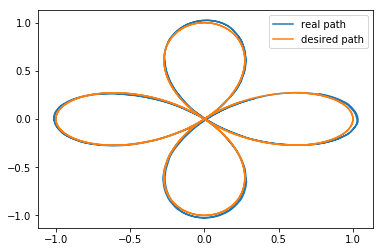

In [132]:
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
ax.legend(['real path', 'desired path'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.show()

In [125]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

print(RMSE_x_nt)
print(RMSE_y_nt)
print(RMSE_theta_nt)

0.1232526525609053
0.12380877857740097
0.009433678893105223
0.008782223282446886
0.008850987391340664
0.009430837303185282


In [121]:
print(pdata)

      globaltime       x_r       y_r   theta_r       x_d       y_d  theta_d  \
0       2.033168  0.333186  0.021696 -0.006021  0.890134  0.192438        0   
1       2.052788  0.336637  0.022511 -0.006272  0.888071  0.193902        0   
2       2.069066  0.340136  0.023284 -0.006696  0.886346  0.195109        0   
3       2.088500  0.343632  0.024171 -0.007198  0.884271  0.196540        0   
4       2.108746  0.347135  0.025052 -0.007384  0.882092  0.198019        0   
5       2.128259  0.350612  0.025895 -0.007930  0.879975  0.199434        0   
6       2.148024  0.353950  0.026833 -0.008656  0.877813  0.200855        0   
7       2.167992  0.357594  0.027668 -0.008729  0.875611  0.202279        0   
8       2.187984  0.361278  0.028617 -0.009196  0.873390  0.203693        0   
9       2.207809  0.364839  0.029465 -0.009013  0.871169  0.205083        0   
10      2.233262  0.368381  0.030256 -0.009443  0.868294  0.206850        0   
11      2.250303  0.371845  0.031182 -0.009595  0.86

In [ ]:
0.01646801994147632
0.025741589380123338
0.01800937355416604